# Import Package

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import xlrd
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import ttest_ind

# Read Data

In [65]:
customerdata = pd.read_csv(r'./QVI_purchase_behaviour.csv')
transactiondata = pd.read_excel(r'./QVI_transaction_data.xlsx')

In [66]:
customerdata.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [67]:
transactiondata.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


# Clean Data & Exploratory Data Analysis

## General

Check for null data

In [68]:
customerdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [69]:
transactiondata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


In [70]:
# Check for duplicate
print(customerdata.duplicated().sum())
print(transactiondata.duplicated().sum())

0
1


In [71]:
# Remove Duplicate
transactiondata.drop_duplicates(inplace=True)

## Transaction

In [72]:
# Keep a copy for a quick reset
transaction_df = transactiondata.copy()

In [73]:
# Convert Date format into YYYY-MM-DD
transaction_df['DATE'] = pd.to_datetime(transaction_df['DATE'], unit='D', origin='1899-12-30')

In [74]:
# View unique product name ensuring that we only examining the chip
transaction_df['PROD_NAME'].unique()

array(['Natural Chip        Compny SeaSalt175g',
       'CCs Nacho Cheese    175g',
       'Smiths Crinkle Cut  Chips Chicken 170g',
       'Smiths Chip Thinly  S/Cream&Onion 175g',
       'Kettle Tortilla ChpsHny&Jlpno Chili 150g',
       'Old El Paso Salsa   Dip Tomato Mild 300g',
       'Smiths Crinkle Chips Salt & Vinegar 330g',
       'Grain Waves         Sweet Chilli 210g',
       'Doritos Corn Chip Mexican Jalapeno 150g',
       'Grain Waves Sour    Cream&Chives 210G',
       'Kettle Sensations   Siracha Lime 150g',
       'Twisties Cheese     270g', 'WW Crinkle Cut      Chicken 175g',
       'Thins Chips Light&  Tangy 175g', 'CCs Original 175g',
       'Burger Rings 220g', 'NCC Sour Cream &    Garden Chives 175g',
       'Doritos Corn Chip Southern Chicken 150g',
       'Cheezels Cheese Box 125g', 'Smiths Crinkle      Original 330g',
       'Infzns Crn Crnchers Tangy Gcamole 110g',
       'Kettle Sea Salt     And Vinegar 175g',
       'Smiths Chip Thinly  Cut Original 175g', 'K

In [75]:
# Remove digits from the product name
prod_name = transaction_df['PROD_NAME'].str.replace(r'\d+[gG]','', regex=True)
# Replace '&' into ' '
prod_name = prod_name.str.replace(r'[&]','', regex=True)

Check for product that may not be chips by examining words contained in the name

In [76]:
word_counts = pd.Series(''.join(prod_name).split()).value_counts()

with pd.option_context('display.max_rows', None): # show all rows
  display(word_counts)

Chips                       49770
Kettle                      38851
Cheese                      27890
Smiths                      26968
Salt                        24719
Crinkle                     23960
Pringles                    23552
Doritos                     23431
Corn                        22063
Original                    21560
Cut                         20753
Chip                        18645
Salsa                       18094
Chicken                     15406
Sea                         14145
Chilli                      13895
Sour                        13882
Thins                       13183
Crisps                      12607
Vinegar                     12402
RRD                         11090
Supreme                     10963
Infuzions                   10371
Popd                         9693
WW                           9592
Tortilla                     9580
Sensations                   9429
Paso                         9324
El                           9324
Dip           

Remove rows containing salsa to ensure that we are only examining chips

In [77]:
transaction_df =transaction_df[transaction_df['PROD_NAME'].str.contains(r'[Ss]alsa') ==False]
transaction_df.shape

(246741, 8)

We will see transaction_df summary to detect outliers

In [78]:
transaction_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246741,246741.000000,2.467410e+05,2.467410e+05,246741.000000,246741.000000,246741.000000
mean,2018-12-30 01:19:32.745510656,135.051212,1.355311e+05,1.351312e+05,56.351835,1.908061,7.321328
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756900e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351840e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030840e+05,2.026540e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,200.000000,650.000000
std,NaN,76.787231,8.071542e+04,7.814786e+04,33.695488,0.659832,3.077833


We see that there is a transaction with 200 packages. Investigate further

In [79]:
transaction_df[transaction_df['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


It seems like it was made by one person. Let us see the other transaction made by the same person

In [80]:
transaction_df[transaction_df['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme 380g,200,650.0
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme 380g,200,650.0


There seems to be none. So, we will remove the transaction from the dataset

In [81]:
transaction_df = transaction_df[transaction_df['LYLTY_CARD_NBR'] != 226000]
transaction_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8
...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8


In [82]:
# Recheck the data
transaction_df.describe()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES
count,246739,246739.000000,2.467390e+05,2.467390e+05,246739.000000,246739.000000,246739.000000
mean,2018-12-30 01:19:29.982856448,135.050474,1.355304e+05,1.351305e+05,56.352259,1.906456,7.316118
min,2018-07-01 00:00:00,1.000000,1.000000e+03,1.000000e+00,1.000000,1.000000,1.700000
25%,2018-09-30 00:00:00,70.000000,7.001500e+04,6.756850e+04,26.000000,2.000000,5.800000
50%,2018-12-30 00:00:00,130.000000,1.303670e+05,1.351820e+05,53.000000,2.000000,7.400000
75%,2019-03-31 00:00:00,203.000000,2.030835e+05,2.026525e+05,87.000000,2.000000,8.800000
max,2019-06-30 00:00:00,272.000000,2.373711e+06,2.415841e+06,114.000000,5.000000,29.500000
std,NaN,76.787105,8.071534e+04,7.814774e+04,33.695295,0.342500,2.474901


The summary looks reasonable now. Let us check whether there is missing data for a particular days

In [83]:
# Count date that has transaction to see whether the data is complete or not
count = transaction_df.groupby(transaction_df['DATE'].dt.date).size().reset_index(name = 'Count')
count.shape

(364, 2)

There seems to be one day of missing data. Check

In [84]:
transaction_df.sort_values(by='DATE')

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
34570,2018-07-01,28,28041,24771,2,Cobs Popd Sour Crm &Chives Chips 110g,2,7.6
259212,2018-07-01,19,19180,16403,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,2,9.2
217565,2018-07-01,7,7139,6843,75,Cobs Popd Sea Salt Chips 110g,1,3.8
13619,2018-07-01,191,191122,192479,20,Doritos Cheese Supreme 330g,2,11.4
27613,2018-07-01,225,225011,224717,32,Kettle Sea Salt And Vinegar 175g,2,10.8
...,...,...,...,...,...,...,...,...
174727,2019-06-30,57,57185,52337,106,Natural ChipCo Hony Soy Chckn175g,2,6.0
244035,2019-06-30,71,71070,69372,5,Natural Chip Compny SeaSalt175g,2,6.0
223440,2019-06-30,147,147201,146941,10,RRD SR Slow Rst Pork Belly 150g,2,5.4
8777,2019-06-30,80,80050,78475,70,Tyrrells Crisps Lightly Salted 165g,2,8.4


In [85]:
# Make a list of all transaction dates
date_counts = transaction_df.groupby('DATE').size()

# Comparing data with full list of dates
pd.date_range(start= '2018-07-01', end= '2019-06-30').difference(date_counts.index)

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq='D')

The missing date was on christmas. So, it is expected that there are no sales. Continue to search for any other outliers

In [86]:
# Examine pack size
# Add a new column to data with packet sizes and extract sizes from product name column
transaction_df.insert(8, "PACK_SIZE", transaction_df['PROD_NAME'].str.extract('(\d+)').astype(float), True)

# Sort by packet sizes to check for outliers 
transaction_df.sort_values(by='PACK_SIZE')

<>:3: SyntaxWarning: invalid escape sequence '\d'
<>:3: SyntaxWarning: invalid escape sequence '\d'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7668\3351617163.py:3: SyntaxWarning: invalid escape sequence '\d'
  transaction_df.insert(8, "PACK_SIZE", transaction_df['PROD_NAME'].str.extract('(\d+)').astype(float), True)


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
204164,2019-05-17,97,97002,96275,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
259246,2019-03-08,20,20172,17144,38,Infuzions Mango Chutny Papadums 70g,1,2.4,70.0
162114,2018-09-29,147,147235,147142,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
89479,2019-05-21,122,122155,125549,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
230231,2018-11-21,43,43063,39006,38,Infuzions Mango Chutny Papadums 70g,2,4.8,70.0
...,...,...,...,...,...,...,...,...,...
17941,2018-10-19,27,27290,24379,4,Dorito Corn Chp Supreme 380g,2,13.0,380.0
17944,2019-01-26,27,27342,24451,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380.0
244521,2018-12-03,78,78029,75634,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380.0
244512,2018-12-28,78,78021,75589,14,Smiths Crnkle Chip Orgnl Big Bag 380g,2,11.8,380.0


Text(0, 0.5, 'Quantity')

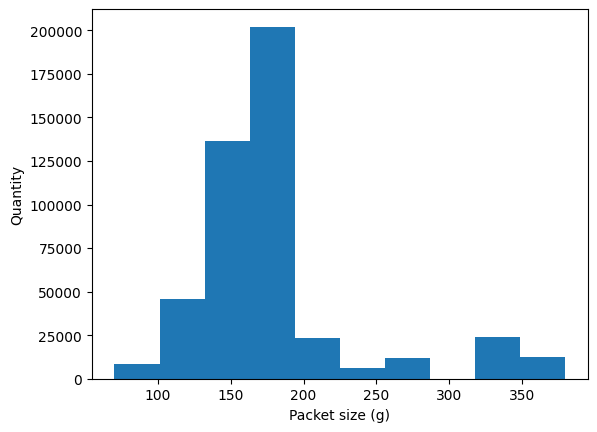

In [87]:
# Plot a histogram to visualise distribution of pack sizes. 
plt.hist(transaction_df['PACK_SIZE'], weights=transaction_df['PROD_QTY'])
plt.xlabel('Packet size (g)')
plt.ylabel('Quantity')

Based on the graph, it seems reasonable. We will move to the next part.
Let us extract brand name from the chips.

In [88]:
# Create brand name using first word of each product name
transaction_df.insert(9, 'BRAND_NAME', transaction_df['PROD_NAME'].str.split().str.get(0), True)
transaction_df

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175.0,CCs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170.0,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175.0,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150.0,Kettle
...,...,...,...,...,...,...,...,...,...,...
264831,2019-03-09,272,272319,270088,89,Kettle Sweet Chilli And Sour Cream 175g,2,10.8,175.0,Kettle
264832,2018-08-13,272,272358,270154,74,Tostitos Splash Of Lime 175g,1,4.4,175.0,Tostitos
264833,2018-11-06,272,272379,270187,51,Doritos Mexicana 170g,2,8.8,170.0,Doritos
264834,2018-12-27,272,272379,270188,42,Doritos Corn Chip Mexican Jalapeno 150g,2,7.8,150.0,Doritos


In [89]:
# Show unique brand name
transaction_df['BRAND_NAME'].unique()

array(['Natural', 'CCs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'WW', 'Thins', 'Burger', 'NCC', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'GrnWves',
       'Tyrrells', 'Cobs', 'French', 'RRD', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

Some has duplicates. We need to change it

In [90]:

# Create a function to identify the string replacements needed.
def replace_brandname(line):
    name = line['BRAND_NAME']
    if name == "Infzns":
        return "Infuzions"
    elif name == "Red":
        return "Red Rock Deli"
    elif name == "RRD":
        return "Red Rock Deli"
    elif name == "Grain":
        return "Grain Waves"
    elif name == "GrnWves":
        return "Grain Waves"
    elif name == "Snbts":
        return "Sunbites"
    elif name == "Natural":
        return "Natural Chip Co"
    elif name == "NCC":
        return "Natural Chip Co"
    elif name == "WW":
        return "Woolworths"
    elif name == "Smith":
        return "Smiths"
    elif name == "Dorito":
        return "Doritos"
    else:
        return name 

# Apply the function to clean the brand names
transaction_df["BRAND_NAME"] = transaction_df.apply(lambda line: replace_brandname(line), axis=1)

# Check that there are no duplicate brands 
transaction_df["BRAND_NAME"].unique()

array(['Natural Chip Co', 'CCs', 'Smiths', 'Kettle', 'Grain Waves',
       'Doritos', 'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

## Purchase

In [91]:
# Create a copy for quick reset
customer_df = customerdata.copy()

In [92]:
# Rename column for better readability
customer_df = customer_df.rename(columns={'PREMIUM_CUSTOMER':'MEMBER_TYPE'})

In [93]:
# Check the summary of customer data
customer_df.describe()

,LYLTY_CARD_NBR
count,7.263700e+04
mean,1.361859e+05
std,8.989293e+04
min,1.000000e+03
25%,6.620200e+04
50%,1.340400e+05
75%,2.033750e+05
max,2.373711e+06


In [94]:
# Check the category in LIFESTAGE and MEMBER_TYPE
print(customer_df['LIFESTAGE'].unique())
print(customer_df['MEMBER_TYPE'].unique())

['YOUNG SINGLES/COUPLES' 'YOUNG FAMILIES' 'OLDER SINGLES/COUPLES'
 'MIDAGE SINGLES/COUPLES' 'NEW FAMILIES' 'OLDER FAMILIES' 'RETIREES']
['Premium' 'Mainstream' 'Budget']


The data seems to be fine. We will proceed to add information to the data (join the cleaned data)

In [95]:
full_df = transaction_df.set_index('LYLTY_CARD_NBR').join(customer_df.set_index('LYLTY_CARD_NBR'))
full_df = full_df.reset_index()
full_df = full_df.sort_values(by='DATE').reset_index(drop=True)
full_df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND_NAME,LIFESTAGE,MEMBER_TYPE
0,28041,2018-07-01,28,24771,2,Cobs Popd Sour Crm &Chives Chips 110g,2,7.6,110.0,Cobs,OLDER FAMILIES,Budget
1,19180,2018-07-01,19,16403,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,2,9.2,150.0,Kettle,YOUNG SINGLES/COUPLES,Premium
2,7139,2018-07-01,7,6843,75,Cobs Popd Sea Salt Chips 110g,1,3.8,110.0,Cobs,YOUNG FAMILIES,Premium
3,191122,2018-07-01,191,192479,20,Doritos Cheese Supreme 330g,2,11.4,330.0,Doritos,MIDAGE SINGLES/COUPLES,Mainstream
4,225011,2018-07-01,225,224717,32,Kettle Sea Salt And Vinegar 175g,2,10.8,175.0,Kettle,NEW FAMILIES,Budget
...,...,...,...,...,...,...,...,...,...,...,...,...
246734,57185,2019-06-30,57,52337,106,Natural ChipCo Hony Soy Chckn175g,2,6.0,175.0,Natural Chip Co,RETIREES,Premium
246735,71070,2019-06-30,71,69372,5,Natural Chip Compny SeaSalt175g,2,6.0,175.0,Natural Chip Co,YOUNG SINGLES/COUPLES,Mainstream
246736,147201,2019-06-30,147,146941,10,RRD SR Slow Rst Pork Belly 150g,2,5.4,150.0,Red Rock Deli,YOUNG FAMILIES,Premium
246737,80050,2019-06-30,80,78475,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165.0,Tyrrells,MIDAGE SINGLES/COUPLES,Mainstream


In [96]:
# Check for null
full_df.isnull().values.any()

np.False_

In [97]:
# Check for duplicate
full_df.duplicated().values.any()

np.False_

In [98]:
# Export the data
full_df.to_csv('QVI_fulldata.csv')

# Data analysis on customer segments

In [99]:
full_df = pd.read_csv(r'./QVI_fulldata.csv')

Calculate total sales by lifestage and member type

In [100]:
total_sales_cust = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['TOT_SALES'].agg(['sum'])
total_sales_cust = total_sales_cust.rename(columns={'sum': 'TOTAL_SALES'})
total_sales_cust.sort_values(by = "TOTAL_SALES", ascending = False)

TOTAL_SALES
LIFESTAGE              MEMBER_TYPE             
OLDER FAMILIES         Budget         156863.75
YOUNG SINGLES/COUPLES  Mainstream     147582.20
RETIREES               Mainstream     145168.95
YOUNG FAMILIES         Budget         129717.95
OLDER SINGLES/COUPLES  Budget         127833.60
                       Mainstream     124648.50
                       Premium        123531.55
RETIREES               Budget         105916.30
OLDER FAMILIES         Mainstream      96413.55
RETIREES               Premium         91296.65
YOUNG FAMILIES         Mainstream      86338.25
MIDAGE SINGLES/COUPLES Mainstream      84734.25
YOUNG FAMILIES         Premium         78571.70
OLDER FAMILIES         Premium         75242.60
YOUNG SINGLES/COUPLES  Budget          57122.10
MIDAGE SINGLES/COUPLES Premium         54443.85
YOUNG SINGLES/COUPLES  Premium         39052.30
MIDAGE SINGLES/COUPLES Budget          33345.70
NEW FAMILIES           Budget          20607.45
                       Mainstream      15979.70
                       Premium         10760.80

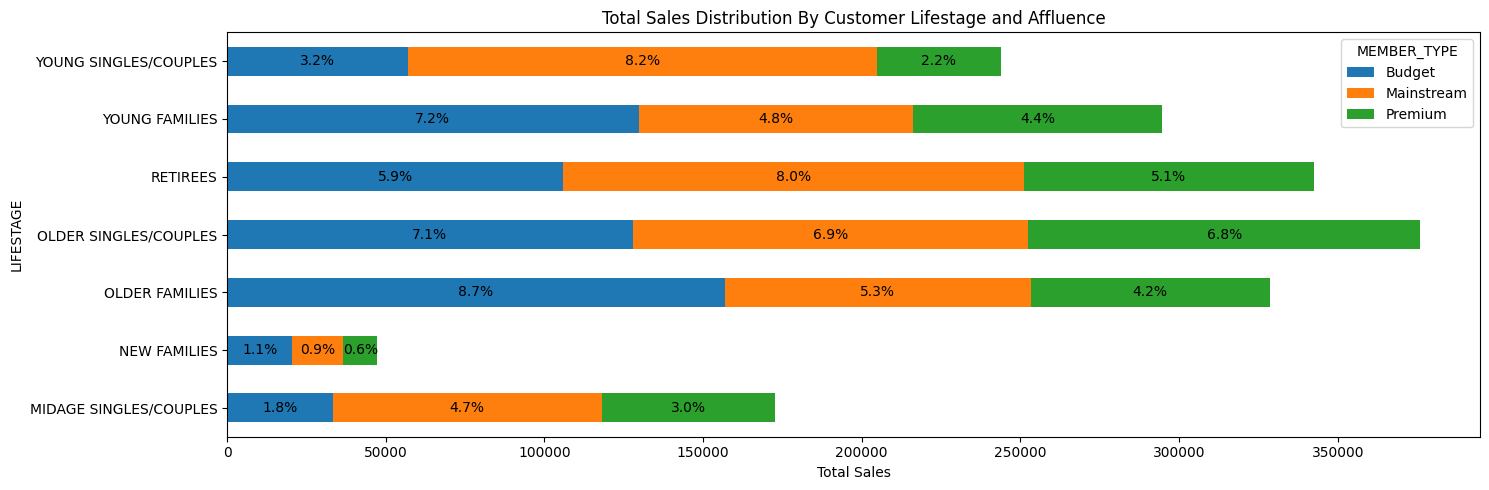

In [136]:
# Create barh graph for better readability
# Get the total sales 
total_sales = full_df['TOT_SALES'].agg(['sum'])['sum']

# Plot a breakdown of the total sales by lifestage and member type
total_sales_breakdown = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['TOT_SALES'].agg(['sum', 'mean']).unstack('MEMBER_TYPE').fillna(0)

# Define a custom color palette: blue, orange, green
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Create the horizontal stacked bar plot
fig, ax = plt.subplots(figsize=(15, 5))
total_sales_breakdown['sum'].plot(kind='barh', stacked=True, ax=ax, color=colors)

# Add labels using ax.bar_label with percentage of total sales
for container in ax.containers:
    labels = [f'{(rect.get_width() / total_sales * 100):.1f}%' for rect in container]
    ax.bar_label(container, labels=labels, label_type='center', fontsize=10, color='black')

# Customize the plot
ax.set_xlabel("Total Sales")
ax.set_title('Total Sales Distribution By Customer Lifestage and Affluence')
plt.tight_layout()

# Show the plot
plt.show()

From the graph, we can see that most sales come from Older Families-Budget, Young Singles/Couples-Mainstream, and Retirees-Mainstream. We will see if the those sales are high because the number of customer from each segment.

In [102]:
# Check all rows are unique in customer information
len(customer_df['LYLTY_CARD_NBR'].unique()) == customer_df.shape[0]

True

In [103]:
# Check if all customers made chip purchases. 
len(customer_df['LYLTY_CARD_NBR'].unique()) == len(full_df['LYLTY_CARD_NBR'].unique())

False

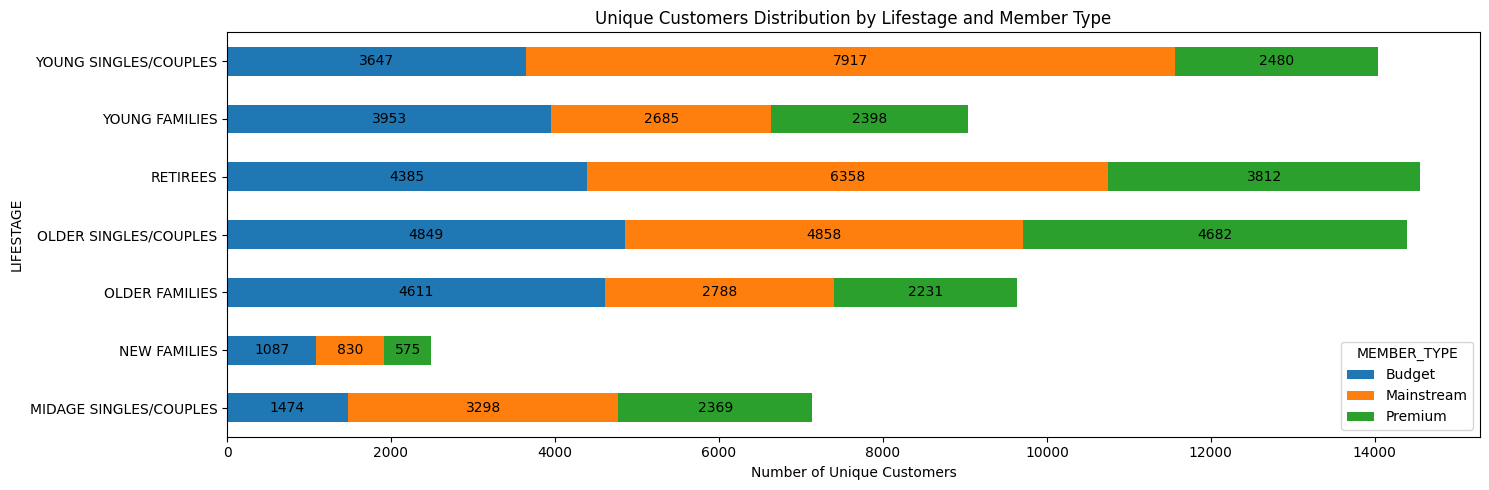

In [129]:
sum_customers = full_df.groupby(['LIFESTAGE', 'MEMBER_TYPE'])['LYLTY_CARD_NBR'].agg('nunique').unstack('MEMBER_TYPE').fillna(0)

# Define a custom color palette: blue, orange, green
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

# Plot the number of unique customers by lifestage and member type
fig, ax = plt.subplots(figsize=(15, 5))
sum_customers.plot(kind='barh', stacked=True, ax=ax, color=colors)

# Add labels using ax.bar_label
for container in ax.containers:
    ax.bar_label(container, label_type='center', fontsize=10, color='black')

# Customize the plot
ax.set_xlabel("Number of Unique Customers")
ax.set_title('Unique Customers Distribution by Lifestage and Member Type')
plt.tight_layout()

# Show the plot
plt.show()

Based on the graph, Young Singles/Couples-Mainstream and Retirees-Mainstream has more customer. Thus, it contributes to the increase of sales for those segments. But, this is not the case for Older Families-Budget segment.

We will see the number of transaction per customer based on LIFESTAGE and MEMBER_TYPE

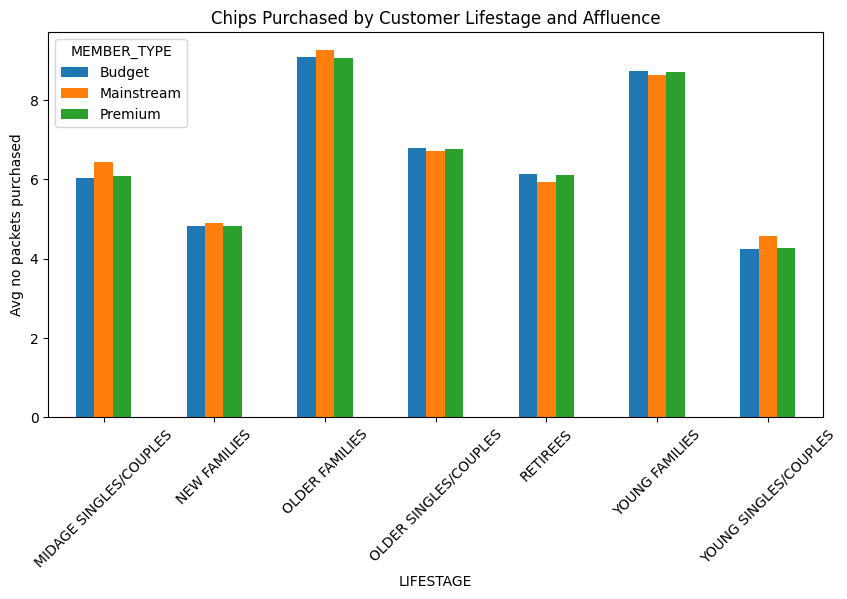

In [106]:
# Plot the average no of chip packets bought per customer by LIFESTAGE and MEMBER_TYPE.
no_packets_data = full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['PROD_QTY'].sum()/full_df.groupby(['LIFESTAGE','MEMBER_TYPE'])['LYLTY_CARD_NBR'].nunique(0)
ax = no_packets_data.unstack('MEMBER_TYPE').fillna(0).plot.bar(stacked = False,figsize=(10, 5))
ax.set_ylabel("Avg no packets purchased")
ax.set_title('Chips Purchased by Customer Lifestage and Affluence')
plt.xticks(rotation=45)
plt.show()

Based on the graph, Older Families and Young Families tend to buy more chips per customer. We will also see the average price per unit bought by each group of LIFESTAGE and MEMBER_TYPE

In [107]:
# Create a column for the unit price of chips purchased per transaction 
full_df['UNIT_PRICE'] = full_df['TOT_SALES']/full_df['PROD_QTY']

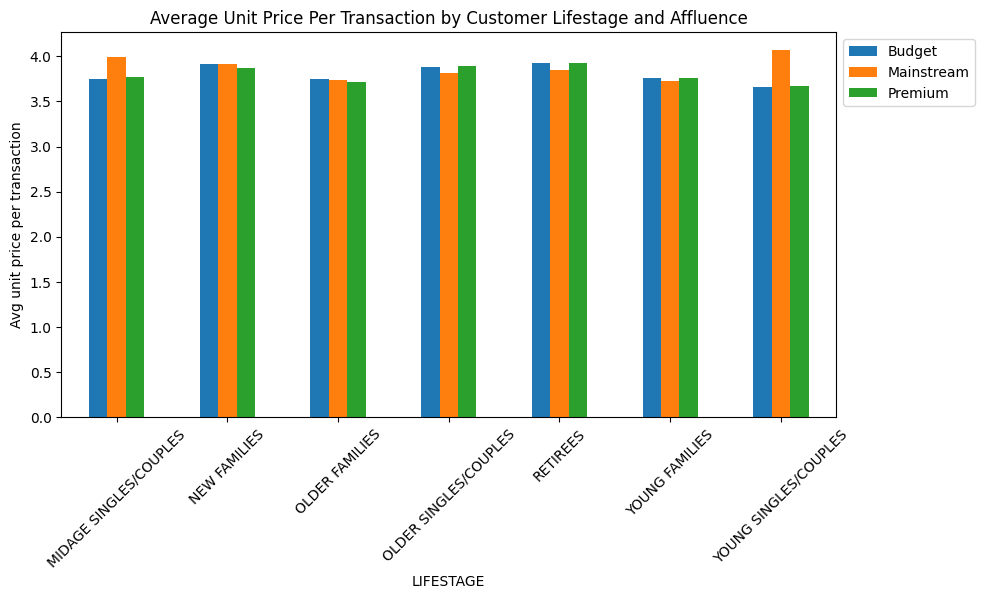

In [108]:
# Plot the distribution of the average unit price per transaction by LIFESTAGE and MEMBER_TYPE.
avg_priceperunit = full_df.groupby(['LIFESTAGE', 'MEMBER_TYPE'])['UNIT_PRICE'].agg(['mean']).unstack('MEMBER_TYPE').fillna(0)
ax = avg_priceperunit['mean'].plot.bar(stacked=False, figsize=(10, 5))
ax.set_ylabel("Avg unit price per transaction")
ax.set_title('Average Unit Price Per Transaction by Customer Lifestage and Affluence')
plt.legend(loc = "upper left",bbox_to_anchor=(1.0, 1.0))
plt.xticks(rotation=45)
plt.show()

For young and midage singles/couples, the mainstream group are willing to pay more for a packet of chips than their budget and premium counterpart. Given from the total sales and the number of customers buying chips, mainstream group has higher sales compared to the non-mainstream groups. This suggests that chips may not be the choice of snack for these groups. Further information on shopping habits would be useful in this case.

We will conduct t-test to see if there is significant difference between the average price per transaction of the mainstream and the non-mainstream.

In [109]:
# Check the difference in the average price unit between the mainstream and premium/budget groups for young/midage singles/couples
# Identify the groups to test the hypthesis with t-test
mainstream = full_df["MEMBER_TYPE"] == "Mainstream"
young_midage = (full_df["LIFESTAGE"] == "MIDAGE SINGLES/COUPLES") | (full_df["LIFESTAGE"] == "YOUNG SINGLES/COUPLES")
premium_budget = full_df["MEMBER_TYPE"] != "Mainstream"

group1 = full_df[mainstream & young_midage]["UNIT_PRICE"]
group2 = full_df[premium_budget & young_midage]["UNIT_PRICE"]

# Generate the t-test 
stat, pval = ttest_ind(group1.values, group2.values, equal_var=False)

print(pval, stat)

6.967354232966617e-306 37.6243885962297


Because the p-value is close to 0, it means that that the null hypothesis is rejected, which is average price unit between the mainstream and premium/budget groups for young/midage singles/couples is the same. In conclusion, unit price for mainstream, young and mid-age singles and couples are significantly higher than that of budget or premium, young and midage singles and couples.

Next, we will analyze the customer segment that contribute the most to sale. It is needed to further increase sale or retain the customer segment. Bases on the analysis above, we will analyze Mainstream - young singles/couples.

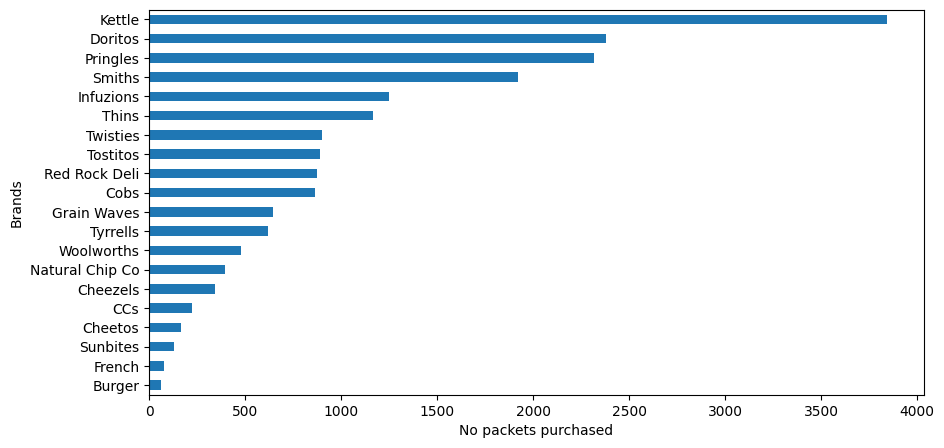

In [110]:
# Create a visual of what brands young singles/couples are purchasing the most for a general indication
young_mainstream = full_df.loc[full_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).plot.barh(figsize=(10, 5))
ax.set_xlabel("No packets purchased")
ax.set_ylabel("Brands")
plt.show()

In [111]:
# Create copy for quick reset
temp = full_df.copy()
temp["group"] = temp["LIFESTAGE"] + ' - ' + temp['MEMBER_TYPE']

Let us do market basket analysis by doing apriori algorithm

In [112]:
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["BRAND_NAME"])
groups_brands = groups.join(brands)
groups_brands = groups_brands.astype(int)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,...,Natural Chip Co,Pringles,Red Rock Deli,Smiths,Sunbites,Thins,Tostitos,Twisties,Tyrrells,Woolworths
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246734,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
246735,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
246736,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
246737,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [113]:
freq_groupsbrands = apriori(groups_brands, min_support=0.008, use_colnames=True)
rules = association_rules(freq_groupsbrands, metric="lift", min_threshold=0.5)
rules.sort_values('confidence', ascending = False, inplace = True)

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [114]:
set_temp = temp["group"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
40,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.079209,0.167335,0.015579,0.196684,1.175395,0.002325,1.036536,0.162059
0,(MIDAGE SINGLES/COUPLES - Mainstream),(Kettle),0.044967,0.167335,0.008657,0.192519,1.150503,0.001132,1.031189,0.136975
23,(RETIREES - Budget),(Kettle),0.057652,0.167335,0.010505,0.182214,1.088922,0.000858,1.018195,0.086656
32,(RETIREES - Premium),(Kettle),0.049591,0.167335,0.008981,0.181105,1.082291,0.000683,1.016816,0.080002
12,(OLDER SINGLES/COUPLES - Budget),(Kettle),0.069596,0.167335,0.012422,0.178488,1.066654,0.000776,1.013577,0.067163
20,(OLDER SINGLES/COUPLES - Premium),(Kettle),0.067111,0.167335,0.011944,0.177970,1.063555,0.000714,1.012937,0.064056
26,(RETIREES - Mainstream),(Kettle),0.080936,0.167335,0.013723,0.169554,1.013265,0.000180,1.002673,0.014244
17,(OLDER SINGLES/COUPLES - Mainstream),(Kettle),0.069146,0.167335,0.011490,0.166168,0.993030,-0.000081,0.998601,-0.007483
34,(YOUNG FAMILIES - Budget),(Kettle),0.071991,0.167335,0.011117,0.154422,0.922834,-0.000930,0.984729,-0.082658
4,(OLDER FAMILIES - Budget),(Kettle),0.087193,0.167335,0.013456,0.154318,0.922212,-0.001135,0.984608,-0.084590


In [115]:
rules[rules['antecedents'] == {'YOUNG SINGLES/COUPLES - Mainstream'}]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
40,(YOUNG SINGLES/COUPLES - Mainstream),(Kettle),0.079209,0.167335,0.015579,0.196684,1.175395,0.002325,1.036536,0.162059
39,(YOUNG SINGLES/COUPLES - Mainstream),(Doritos),0.079209,0.102229,0.009642,0.121725,1.190707,0.001544,1.022198,0.173940
43,(YOUNG SINGLES/COUPLES - Mainstream),(Pringles),0.079209,0.101735,0.009382,0.118451,1.164306,0.001324,1.018962,0.153259


From the apriori algorithm, we see that YOUNG SINGLES/COUPLES - Mainstream pick Kettle as a brand choice. This case also happen to most of the other segment.

Next, we will use affinity analysis to see if the target segment loves any other brand.

In [116]:
# find the target rating proportion
target_segment = young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

# find the other rating proportion
not_young_mainstream = full_df.loc[full_df['LIFESTAGE'] != "YOUNG SINGLES/COUPLES"]
not_young_mainstream = not_young_mainstream.loc[not_young_mainstream['MEMBER_TYPE'] != "Mainstream"]
other = not_young_mainstream["BRAND_NAME"].value_counts().sort_values(ascending = True).rename_axis('BRANDS').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

# join the two dataframes 
brand_proportions = target_segment.set_index('BRANDS').join(other.set_index('BRANDS'))
# full_df = trans_df.set_index('LYLTY_CARD_NBR').join(cust_df.set_index('LYLTY_CARD_NBR'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,BRANDS,target,other,affinity
8,Tyrrells,0.017088,0.013368,1.278261
13,Twisties,0.024845,0.019633,1.265487
18,Doritos,0.065673,0.052512,1.250637
12,Tostitos,0.024569,0.019944,1.231902
19,Kettle,0.106115,0.086574,1.225703
17,Pringles,0.063906,0.052477,1.217784
10,Cobs,0.023851,0.020004,1.192284
15,Infuzions,0.034507,0.029931,1.152881
9,Grain Waves,0.017833,0.016214,1.099869
14,Thins,0.032188,0.029771,1.081164


By seeing the result above, mainstream young singles/couples are likely to purchase a certain brand that has affinity greater than 1. The opposite happen when the affinity is less than 1. Based on it, the mainstream young singles/couples is 27,8% more likely to purchase Tyrrells. Mainstream young singles/couples also less likely to purchase 'burger'

Let us see the size of the package that mainstream young singles/couples tend to buy.

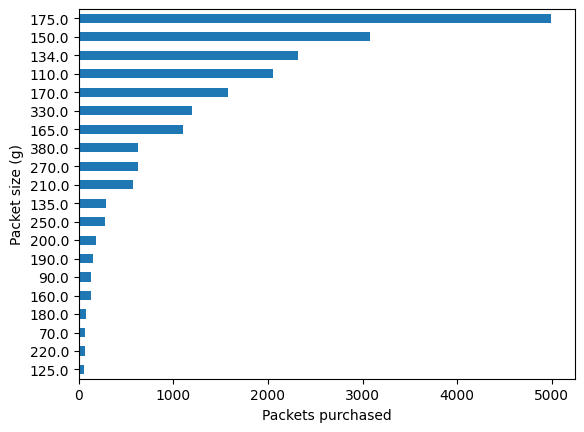

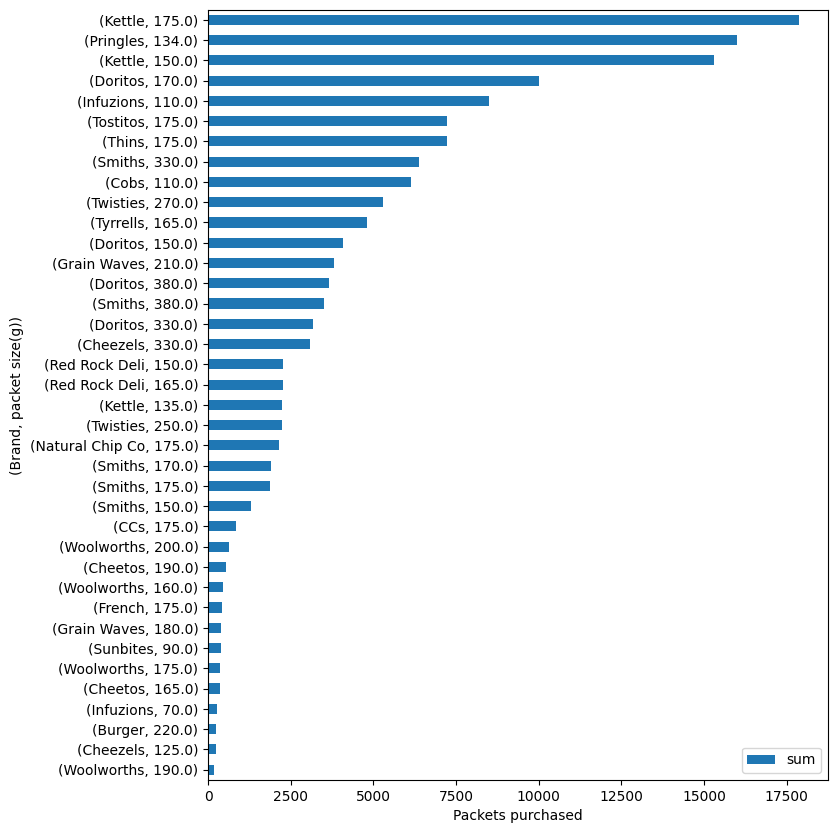

In [117]:
# Plot the distribution of the packet sizes for a general indication of what it most popular. 
young_mainstream = full_df.loc[full_df['LIFESTAGE'] == "YOUNG SINGLES/COUPLES"]
young_mainstream = young_mainstream.loc[young_mainstream['MEMBER_TYPE'] == "Mainstream"]
ax = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).plot.barh()
ax.set_ylabel("Packet size (g)")
ax.set_xlabel("Packets purchased")
plt.show()

brand_size = young_mainstream.groupby(['BRAND_NAME','PACK_SIZE'])['TOT_SALES'].agg(['sum'])
ax = brand_size.sort_values(by = 'sum').plot.barh(y = "sum", figsize=(8,10))
ax.set_ylabel("(Brand, packet size(g))")
ax.set_xlabel("Packets purchased")
plt.show()

In [118]:
# We will do apriori alogorithm again
groups = pd.get_dummies(temp["group"])
brands = pd.get_dummies(temp["PACK_SIZE"])
groups_brands = groups.join(brands)
groups_brands = groups_brands.astype(int)
groups_brands

,MIDAGE SINGLES/COUPLES - Budget,MIDAGE SINGLES/COUPLES - Mainstream,MIDAGE SINGLES/COUPLES - Premium,NEW FAMILIES - Budget,NEW FAMILIES - Mainstream,NEW FAMILIES - Premium,OLDER FAMILIES - Budget,OLDER FAMILIES - Mainstream,OLDER FAMILIES - Premium,OLDER SINGLES/COUPLES - Budget,...,175.0,180.0,190.0,200.0,210.0,220.0,250.0,270.0,330.0,380.0
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246734,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
246735,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
246736,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
246737,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [119]:
freq_groupsbrands = apriori(groups_brands, min_support=0.009, use_colnames=True)
rules = association_rules(freq_groupsbrands, metric="lift", min_threshold=0.5)
rules.sort_values('confidence', ascending = False, inplace = True)
set_temp = temp["group"].unique()
rules[rules["antecedents"].apply(lambda x: list(x)).apply(lambda x: x in set_temp)]

c:\Users\Lenovo\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
38,(YOUNG FAMILIES - Premium),(175.0),0.043706,0.269066,0.012150,0.278004,1.033221,0.000391,1.012381,0.033623
34,(YOUNG FAMILIES - Budget),(175.0),0.071991,0.269066,0.019944,0.277037,1.029624,0.000574,1.011025,0.031004
40,(YOUNG SINGLES/COUPLES - Budget),(175.0),0.034745,0.269066,0.009476,0.272717,1.013569,0.000127,1.005020,0.013869
6,(OLDER FAMILIES - Mainstream),(175.0),0.053664,0.269066,0.014542,0.270977,1.007102,0.000103,1.002621,0.007451
8,(OLDER FAMILIES - Premium),(175.0),0.042162,0.269066,0.011413,0.270691,1.006041,0.000069,1.002229,0.006269
24,(RETIREES - Budget),(175.0),0.057652,0.269066,0.015591,0.270439,1.005105,0.000079,1.001883,0.005390
30,(RETIREES - Premium),(175.0),0.049591,0.269066,0.013399,0.270186,1.004165,0.000056,1.001536,0.004364
4,(OLDER FAMILIES - Budget),(175.0),0.087193,0.269066,0.023539,0.269964,1.003338,0.000078,1.001230,0.003644
12,(OLDER SINGLES/COUPLES - Budget),(175.0),0.069596,0.269066,0.018745,0.269334,1.000996,0.000019,1.000367,0.001070
20,(OLDER SINGLES/COUPLES - Premium),(175.0),0.067111,0.269066,0.018064,0.269159,1.000346,0.000006,1.000127,0.000371


Most segment seems to prefer chips which has 175g.

We will now see if the  mainstream young singles/couples have certain preferences over other segments by using affinity index.

In [120]:
# find the target rating proportion
target_segment = young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='target')
target_segment.target /= young_mainstream["PROD_QTY"].sum()

# find the other rating proportion
other = not_young_mainstream["PACK_SIZE"].value_counts().sort_values(ascending = True).rename_axis('SIZES').reset_index(name='other')
other.other /= not_young_mainstream["PROD_QTY"].sum()

# join the two dataframes 
brand_proportions = target_segment.set_index('SIZES').join(other.set_index('SIZES'))
brand_proportions = brand_proportions.reset_index()
brand_proportions['affinity'] = brand_proportions['target']/brand_proportions['other']
brand_proportions.sort_values(by = 'affinity', ascending = False)

,SIZES,target,other,affinity
11,270.0,0.017115,0.012958,1.320816
12,380.0,0.017281,0.013375,1.291983
14,330.0,0.032988,0.026455,1.246958
10,210.0,0.015901,0.012973,1.225645
17,134.0,0.063906,0.052477,1.217784
16,110.0,0.056618,0.046653,1.213608
9,135.0,0.008006,0.006750,1.185942
8,250.0,0.007729,0.006674,1.158067
15,170.0,0.043478,0.041826,1.039494
18,150.0,0.085024,0.084969,1.000645


Based on the table, mainstream young singles/couples are 32% more likely to puchase 270g chips. But, they are less likely to buy chips which has 220g. This finding is consistent with our finding that the brand 'burger' with 220g is less likely to be purchased rather than 'twisties' that comes in 270g.

# Conclusion

The three highest contributing segments to the total sales are:

1. Older families - Budget
2. Young singles/couples - Mainstream
3. Retirees - Mainstream

The largest consumer group is mainstream young singles and couples, followed by mainstream retirees, which explains their high total sales. Although the number of people isn't a major factor for budget older families, both older and young families generally buy more chips per person. Additionally, mainstream young singles and couples spend more per purchase compared to their non-mainstream counterparts, a difference that is statistically significant. Within the mainstream young singles and couples segment, they are 28% more likely to buy Tyrells chips compared to other segments. This group also buys the most Kettles chips, a trend seen across most segments. However, they are 50% less likely to purchase Burger Rings, which is notable given that Burger Rings are the only chips available in a 220g size. Mainstream young singles and couples are also 32% more likely to choose 270g chips, like Twisties, compared to other segments. Across various segments, the 175g packet size is the most popular.

To target mainstream young singles and couples more effectively, consider placing Tyrells and Twisties where they are more likely to be noticed by this group. Since Kettles chips are the most popular overall, positioning Tyrells and Twisties near Kettles could be beneficial. This approach could also be applied to other segments that buy a lot of Kettles chips to boost their total sales.